In [5]:
import scipy as sp
import scipy.fft as fft
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tqdm

from sys import getsizeof

## Direct Processing

In [213]:
def generate_props(NN, boundary):
    

    mid = NN//2

    xs = np.linspace(-boundary,boundary,NN)
    dx   = (xs[1]-xs[0])
    rs = np.sqrt(xs**2+2.0*(xs[mid])**2)
    ks = np.fft.fftfreq(NN,d=dx)
    rho0 = 1.0/dx**3
    
    props = {'NN':NN, 'mid':mid, 'xs':xs, 'dx':dx, 'rs':rs, 'ks':ks, 'rho0':rho0}
    
    return props

In [193]:
def dir_prepare_delta(props):
    
    NN = props['NN']
    mid = props['mid']
    rho0 = props['rho0']
    
    dset = np.zeros((NN,NN,NN), dtype='complex')
    
    ## construct the density profile by scanning over axis 0

    dset[mid,mid,mid]       = rho0/8.0
    dset[mid-1,mid,mid]     = rho0/8.0
    dset[mid,mid-1,mid]     = rho0/8.0
    dset[mid,mid,mid-1]     = rho0/8.0
    dset[mid-1,mid-1,mid]   = rho0/8.0
    dset[mid,mid-1,mid-1]   = rho0/8.0
    dset[mid-1,mid,mid-1]   = rho0/8.0
    dset[mid-1,mid-1,mid-1] = rho0/8.0
    
    return dset

In [194]:
def dir_get_potential(dset, props, factor):
    
    ks = props['ks']
    
    eps = ks[1]/factor
    

    dset = fft.fft2(dset,axes=(1,2),workers=8)
    dset = fft.fft(dset,axis=0,workers=8)

    kx,ky,kz = np.meshgrid(ks,ks,ks,indexing='ij')
    ksq = np.copy(kx**2+ky**2+kz**2)
    ksq[0,0,0] = eps**2
    del kx,ky,kz
    dset = dset/ksq
    del ksq


    dset = fft.ifft2(dset,axes=(1,2),workers=8)
    dset =  fft.ifft(dset,axis=0,workers=8)/np.pi

    ## The factor of pi comes from 4*pi/(2*pi)^2
    
    return dset

In [195]:
props = generate_props(128,10.0)
rho_delta = dir_prepare_delta(props)

pot_delta = dir_get_potential(rho_delta, props, 3.0)

## Chunked system

In [196]:
def chunked_prepare_delta(filename, props):
    
    NN = props['NN']
    mid = props['mid']
    rho0 = props['rho0']
    
    with h5py.File(filename,'w') as F:
        dset = F.create_dataset('d1',(NN,NN,NN), dtype='complex')
        mid = NN//2
        ## construct the density profile by scanning over axis 0

        dset[mid,mid,mid]       = rho0/8.0
        dset[mid-1,mid,mid]     = rho0/8.0
        dset[mid,mid-1,mid]     = rho0/8.0
        dset[mid,mid,mid-1]     = rho0/8.0
        dset[mid-1,mid-1,mid]   = rho0/8.0
        dset[mid,mid-1,mid-1]   = rho0/8.0
        dset[mid-1,mid,mid-1]   = rho0/8.0
        dset[mid-1,mid-1,mid-1] = rho0/8.0

In [197]:
def chunked_get_potential_v0(filename, props, factor, slices, debug=False, workers=4):
       
    ks = props['ks']
    NN = props['NN']
    
    nn = NN//slices
    
    print(f"Slicing, the memory use will be {16*NN*NN*NN//slices/1e9} GB per array")
    ## This is true for complex arrays. In reality, kx,ky,kz and ksq are smaller because they are real, not complex
    
    eps = ks[1]/factor
    
    show_progress = not debug
        
    
    with h5py.File(filename,'r+') as F:
        dset = F['d1']

        for ii in tqdm.tqdm(range(slices), disable=show_progress):
            a = dset[ii*nn:(ii+1)*nn,:,:]
            dset[ii*nn:(ii+1)*nn] = fft.fft2(a,axes=(1,2),workers=workers)

        for ii in tqdm.tqdm(range(slices), disable=show_progress):
            a = dset[:,ii*nn:(ii+1)*nn,:]
            dset[:,ii*nn:(ii+1)*nn] = fft.fft(a,axis=0,workers=workers)


        for ii in tqdm.tqdm(range(slices), disable=show_progress):
            ksub = ks[ii*nn:(ii+1)*nn]
            kx,ky,kz = np.meshgrid(ksub,ks,ks,indexing='ij')
            ksq = np.copy(kx**2+ky**2+kz**2)
            if ksq[0,0,0] == 0:
                ksq[0,0,0] = eps**2
            del kx,ky,kz
            a = dset[ii*nn:(ii+1)*nn,:,:]
            dset[ii*nn:(ii+1)*nn] = a/ksq

        for ii in tqdm.tqdm(range(slices), disable=show_progress):
            a = dset[ii*nn:(ii+1)*nn,:,:]
            dset[ii*nn:(ii+1)*nn] = fft.ifft2(a,axes=(1,2),workers=workers)

        for ii in tqdm.tqdm(range(slices), disable=show_progress):
            a = dset[:,ii*nn:(ii+1)*nn,:]
            dset[:,ii*nn:(ii+1)*nn] =  fft.ifft(a,axis=0,workers=workers)/np.pi

        ## The last factor of 1/pi comes from 4*pi/(2*pi)^2
    


In [296]:
def chunked_get_potential_v1(filename, props, factor, slices, debug=False, workers=4):
       
    ks = props['ks']
    NN = props['NN']
    
    nn = NN//slices
    
    ##print(f"Slicing, the memory use will be {16*NN*NN*NN//slices/1e9} GB per array")
    ## This is true for complex arrays. In reality, kx,ky,kz and ksq are smaller because they are real, not complex
    
    eps = ks[1]/factor
    
    show_progress = not debug
    
    with h5py.File(filename,'r+') as F:
        dset = F['d1']
       
        for ii in tqdm.tqdm(range(slices), disable=show_progress):
            a = dset[:,ii*nn:(ii+1)*nn,:]
            dset[:,ii*nn:(ii+1)*nn] = fft.fft(a,axis=0,workers=workers)
            
        for ii in tqdm.tqdm(range(slices), disable=show_progress):
            ksub = ks[ii*nn:(ii+1)*nn]
            kx,ky,kz = np.meshgrid(ksub,ks,ks,indexing='ij')
            ksq = np.pi*(kx**2+ky**2+kz**2)
            ## The last factor of pi comes from 4*pi/(2*pi)^2
            if ksq[0,0,0] == 0:
                ksq[0,0,0] = np.pi*eps**2
            del kx,ky,kz
            a = dset[ii*nn:(ii+1)*nn,:,:]
            a = fft.fft2(a,axes=(1,2),workers=workers)
            a = a/ksq
            dset[ii*nn:(ii+1)*nn] = fft.ifft2(a,axes=(1,2),workers=workers)
            
        for ii in tqdm.tqdm(range(slices), disable=show_progress):
            a = dset[:,ii*nn:(ii+1)*nn,:]
            dset[:,ii*nn:(ii+1)*nn] =  fft.ifft(a,axis=0,workers=workers) 


In [498]:
def get_axis(filename, props, axis=0):
    mid = props['mid']
    
    with h5py.File(filename,'r+') as F:
        dset = F['d1']
        if axis == 0:
            myslice = np.copy(dset[mid:,mid,mid])
            return myslice
        if axis == 1:
            myslice = np.copy(dset[mid,mid:,mid])
            return myslice
        if axis == 2:
            myslice = np.copy(dset[mid,mid,mid:])
            return myslice
        
def get_diagonal(filename,props,axis=0):
    with h5py.File(filename,'r+') as F:
        dset = F['d1']
        res = []
        if axis == 0:  #'yz'
            for i in range(mid):
                res.append(dset[mid,mid+i,mid+i])
            return np.array(res)
        
        if axis == 1:  #'xz'
            for i in range(mid):
                res.append(dset[mid+i,mid,mid+i])
            return np.array(res)
        
        if axis == 2:  #'xy'
            for i in range(mid):
                res.append(dset[mid+i,mid+i,mid])
            return np.array(res)
        
def get_full_diagonal(filename,props,axis=0):
    with h5py.File(filename,'r+') as F:
        dset = F['d1']
        res = []
        if axis == 0:  #'xyz'
            for i in range(mid):
                res.append(dset[mid+i,mid+i,mid+i])
            return np.array(res)
        
def get_plane(filename,props,axis=0):
    with h5py.File(filename,'r+') as F:
        dset = F['d1']
        if axis == 0:
            return dset[mid,:,:]
        if axis == 1:
            return dset[:,mid,:]
        if axis == 2:
            return dset[:,:,mid]

In [173]:
%%time

props = generate_props(1024,20.0)
chunked_prepare_delta('test_v1.h5',props)
chunked_get_potential_v1('test_v1.h5',props,2.9,16,debug=True)

  0%|          | 0/16 [00:00<?, ?it/s]

Slicing, the memory use will be 1.073741824 GB per array


 19%|█▉        | 3/16 [00:07<00:33,  2.61s/it]


KeyboardInterrupt: 

## Records of different test runs (memusage taken from System Monitor)

| NN | slices | base mem | mem(stage 1) | net mem(1) | mem(stage 2) | net mem (2) | time |
| --- | --- | --- | --- | --- | --- | --- | --- |
|512  |  2  | 3.8 | 7.5 | 3.7 |     |     |     |
|512  |  4  | 3.8 | 5.8 | 2.0 |     |     |     |
|512  |  8  | 3.8 | 4.8 | 1.0 |     |     |     |
|1024 |  8  | 3.8 | 11.7 | 8.9 | 8.7 | 5.0  |     |
|1024 | 16  | 3.8 | 8.7  | 5.0 | 7.2 | 3.4  |     |
|1536 | 64  | 3.8 | 8.1  | 4.3 | 6.4 | 2.6  | 13mins |
|2048 | 128  | 5.2 | 9.5  | 4.3 | 7.2 | 2.0  | 37mins |
|2048 | 256  | 3.8 | -  | - | 5.8 | 2.0  | 34mins |


In [201]:
## This seems to be a good predictor of mem usage...

def predict_mem(NN,slices):
    return 64*(NN/1024)**3/slices

print(predict_mem(512,2)/3.7)
print(predict_mem(512,4)/2.0)
print(predict_mem(512,8)/1.0)

print(predict_mem(1024,8)/8.0)
print(predict_mem(1024,16)/5.0)
print(predict_mem(1536,64)/4.3)
print(predict_mem(2048,256)/2.0)
print(predict_mem(2048,128)/4.3)

### so the right number of slices is roughly (to use 8GB of memory at most.)

def det_slices(NN, mem=4):
    NNs = np.array(NN)
    pre = np.log((64/mem*(NNs/1024)**3))/np.log(2)
    mask = pre < 0
    pre[mask] = 0
    return np.power(2,(np.ceil(pre))).astype('i')

1.081081081081081
1.0
1.0
1.0
0.8
0.7848837209302326
1.0
0.9302325581395349


In [202]:
NNs = 64*np.power(2,np.arange(8))
slices = det_slices(NNs,mem=4)
print(f"NNs    = {NNs}")
print(f"slices = {slices}")
print(f"mem    = {predict_mem(NNs,slices)}")

NNs    = [  64  128  256  512 1024 2048 4096 8192]
slices = [   1    1    1    2   16  128 1024 8192]
mem    = [0.015625 0.125    1.       4.       4.       4.       4.       4.      ]


In [370]:
NNs = 3*64*np.power(2,np.arange(6))
slices = det_slices(NNs,mem=4)
print(f"NNs    = {NNs}")
print(f"slices = {slices}")
print(f"mem    = {predict_mem(NNs,slices)}")

NNs    = [ 192  384  768 1536 3072 6144]
slices = [   1    1    8   64  512 4096]
mem    = [0.421875 3.375    3.375    3.375    3.375    3.375   ]


## Determining the right factors

In [329]:
%%time

props = generate_props(256,10.0)
chunked_prepare_delta('test_v1.h5',props)
chunked_get_potential_v1('test_v1.h5',props,2.95,1,debug=True)

100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

CPU times: user 3.3 s, sys: 1.08 s, total: 4.38 s
Wall time: 1.84 s


In [330]:
pot_x_axis = np.real(get_axis('test_v1.h5',props,axis=0))
pot_y_axis = np.real(get_axis('test_v1.h5',props,axis=1))
pot_z_axis = np.real(get_axis('test_v1.h5',props,axis=2))

pot_xy_axis = np.real(get_diagonal('test_v1.h5',props,axis=2))
pot_xz_axis = np.real(get_diagonal('test_v1.h5',props,axis=1))
pot_yz_axis = np.real(get_diagonal('test_v1.h5',props,axis=0))

pot_xyz_axis = np.real(get_full_diagonal('test_v1.h5',props,axis=0))

rs = props['rs']

xs = props['xs']

mid = props['mid']

rs_diag = np.sqrt(2.0*xs**2+(xs[mid])**2)
rs_full_diag = np.sqrt(3.0*xs**2)

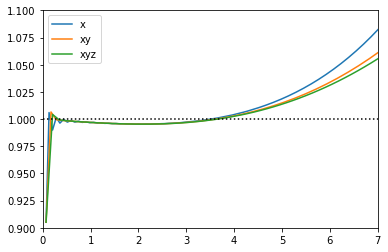

In [331]:
plt.plot(rs[mid:],pot_x_axis*rs[mid:],label='x')
#plt.plot(rs[mid:],pot_y_axis*rs[mid:])
#plt.plot(rs[mid:],pot_z_axis*rs[mid:])

plt.plot(rs_diag[mid:],pot_xy_axis*rs_diag[mid:],label='xy')
#plt.plot(rs_diag[mid:],pot_yz_axis*rs_diag[mid:])
#plt.plot(rs_diag[mid:],pot_xz_axis*rs_diag[mid:])

plt.plot(rs_full_diag[mid:],pot_xyz_axis*rs_full_diag[mid:],label='xyz')

plt.plot([0,7],[1,1],'k:')
plt.legend()
plt.xlim(0,7)
plt.ylim(0.9,1.1)
plt.show()

In [300]:
def merit(pot,rs,lim):

    mask = (0 < rs) & (rs <= lim)
    merit = np.sqrt(np.mean(((pot*rs-1)**2)[mask]))
    
    return merit

## Optimal Factor: NN = 256

100%|██████████| 21/21 [00:43<00:00,  2.06s/it]


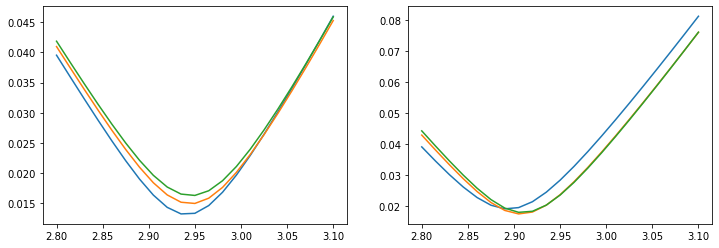

optimal factor for x   (0 < d < 5):  2.935
optimal factor for xy  (0 < d < 5):  2.950
optimal factor for xyz (0 < d < 5):  2.950
optimal factor for x   (0 < d < 7):  2.890
optimal factor for xy  (0 < d < 7):  2.905
optimal factor for xyz (0 < d < 7):  2.905


In [346]:
props = generate_props(256,10.0)

xs = props['xs']
mid = props['mid']
rs = props['rs']
rs_diag = np.sqrt(2.0*xs**2+(xs[mid])**2)
rs_full_diag = np.sqrt(3.0*xs**2)


pot_x = []
pot_xy = []
pot_xyz = []

merits_5 = []
merits_7 = []

factors = np.linspace(2.8,3.1,21)

for factor in tqdm.tqdm(factors):

    chunked_prepare_delta('test_v1.h5',props)
    chunked_get_potential_v1('test_v1.h5',props,factor,1,debug=False)

    pot_x_axis = np.real(get_axis('test_v1.h5',props,axis=0))
    pot_xy_axis = np.real(get_diagonal('test_v1.h5',props,axis=2))
    pot_xyz_axis = np.real(get_full_diagonal('test_v1.h5',props,axis=0))

    pot_x.append(pot_x_axis)
    pot_xy.append(pot_xy_axis)
    pot_xyz.append(pot_xyz_axis)
    
    merits_5.append([merit(pot_x_axis,rs[mid:],5),merit(pot_xy_axis,rs_diag[mid:],5),merit(pot_xyz_axis,rs_full_diag[mid:],5)])
    merits_7.append([merit(pot_x_axis,rs[mid:],7),merit(pot_xy_axis,rs_diag[mid:],7),merit(pot_xyz_axis,rs_full_diag[mid:],7)])

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(factors,np.array(merits_5))
plt.subplot(1,2,2)
plt.plot(factors,np.array(merits_7))
plt.show()

print(f"optimal factor for x   (0 < d < 5):  {factors[np.argmin(np.array(merits_5)[:,0])]:.3f}")
print(f"optimal factor for xy  (0 < d < 5):  {factors[np.argmin(np.array(merits_5)[:,1])]:.3f}")
print(f"optimal factor for xyz (0 < d < 5):  {factors[np.argmin(np.array(merits_5)[:,2])]:.3f}")

print(f"optimal factor for x   (0 < d < 7):  {factors[np.argmin(np.array(merits_7)[:,0])]:.3f}")
print(f"optimal factor for xy  (0 < d < 7):  {factors[np.argmin(np.array(merits_7)[:,1])]:.3f}")
print(f"optimal factor for xyz (0 < d < 7):  {factors[np.argmin(np.array(merits_7)[:,2])]:.3f}")

## Optimal Factor: NN = 512

100%|██████████| 21/21 [05:53<00:00, 16.84s/it]


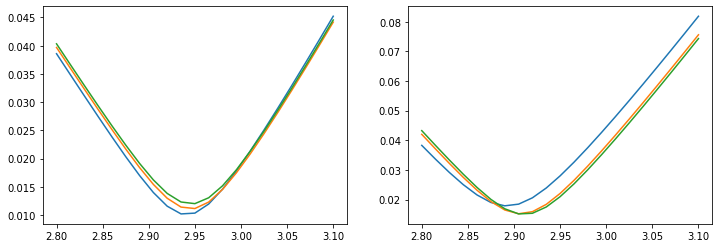

optimal factor for x   (0 < d < 5):  2.935
optimal factor for xy  (0 < d < 5):  2.950
optimal factor for xyz (0 < d < 5):  2.950
optimal factor for x   (0 < d < 7):  2.890
optimal factor for xy  (0 < d < 7):  2.905
optimal factor for xyz (0 < d < 7):  2.905


In [347]:
props = generate_props(512,10.0)

xs = props['xs']
mid = props['mid']
rs = props['rs']
rs_diag = np.sqrt(2.0*xs**2+(xs[mid])**2)
rs_full_diag = np.sqrt(3.0*xs**2)


pot_x = []
pot_xy = []
pot_xyz = []

merits_5 = []
merits_7 = []

factors = np.linspace(2.8,3.1,21)

for factor in tqdm.tqdm(factors):

    chunked_prepare_delta('test_v1.h5',props)
    chunked_get_potential_v1('test_v1.h5',props,factor,2,debug=False)

    pot_x_axis = np.real(get_axis('test_v1.h5',props,axis=0))
    pot_xy_axis = np.real(get_diagonal('test_v1.h5',props,axis=2))
    pot_xyz_axis = np.real(get_full_diagonal('test_v1.h5',props,axis=0))

    pot_x.append(pot_x_axis)
    pot_xy.append(pot_xy_axis)
    pot_xyz.append(pot_xyz_axis)
    
    merits_5.append([merit(pot_x_axis,rs[mid:],5),merit(pot_xy_axis,rs_diag[mid:],5),merit(pot_xyz_axis,rs_full_diag[mid:],5)])
    merits_7.append([merit(pot_x_axis,rs[mid:],7),merit(pot_xy_axis,rs_diag[mid:],7),merit(pot_xyz_axis,rs_full_diag[mid:],7)])

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(factors,np.array(merits_5))
plt.subplot(1,2,2)
plt.plot(factors,np.array(merits_7))
plt.show()

print(f"optimal factor for x   (0 < d < 5):  {factors[np.argmin(np.array(merits_5)[:,0])]:.3f}")
print(f"optimal factor for xy  (0 < d < 5):  {factors[np.argmin(np.array(merits_5)[:,1])]:.3f}")
print(f"optimal factor for xyz (0 < d < 5):  {factors[np.argmin(np.array(merits_5)[:,2])]:.3f}")

print(f"optimal factor for x   (0 < d < 7):  {factors[np.argmin(np.array(merits_7)[:,0])]:.3f}")
print(f"optimal factor for xy  (0 < d < 7):  {factors[np.argmin(np.array(merits_7)[:,1])]:.3f}")
print(f"optimal factor for xyz (0 < d < 7):  {factors[np.argmin(np.array(merits_7)[:,2])]:.3f}")

## Optimal Factor: NN = 1024

100%|██████████| 13/13 [38:33<00:00, 177.95s/it]


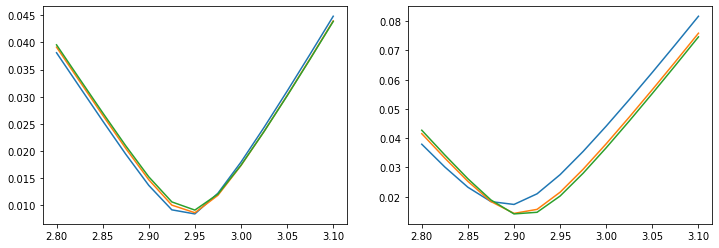

optimal factor for x   (0 < d < 5):  2.950
optimal factor for xy  (0 < d < 5):  2.950
optimal factor for xyz (0 < d < 5):  2.950
optimal factor for x   (0 < d < 7):  2.900
optimal factor for xy  (0 < d < 7):  2.900
optimal factor for xyz (0 < d < 7):  2.900


In [361]:
props = generate_props(1024,10.0)

xs = props['xs']
mid = props['mid']
rs = props['rs']
rs_diag = np.sqrt(2.0*xs**2+(xs[mid])**2)
rs_full_diag = np.sqrt(3.0*xs**2)


pot_x = []
pot_xy = []
pot_xyz = []

merits_5 = []
merits_7 = []

factors = np.linspace(2.8,3.1,13)

for factor in tqdm.tqdm(factors):

    chunked_prepare_delta('test_v1.h5',props)
    chunked_get_potential_v1('test_v1.h5',props,factor,16,debug=False)

    pot_x_axis = np.real(get_axis('test_v1.h5',props,axis=0))
    pot_xy_axis = np.real(get_diagonal('test_v1.h5',props,axis=2))
    pot_xyz_axis = np.real(get_full_diagonal('test_v1.h5',props,axis=0))

    pot_x.append(pot_x_axis)
    pot_xy.append(pot_xy_axis)
    pot_xyz.append(pot_xyz_axis)
    
    merits_5.append([merit(pot_x_axis,rs[mid:],5),merit(pot_xy_axis,rs_diag[mid:],5),merit(pot_xyz_axis,rs_full_diag[mid:],5)])
    merits_7.append([merit(pot_x_axis,rs[mid:],7),merit(pot_xy_axis,rs_diag[mid:],7),merit(pot_xyz_axis,rs_full_diag[mid:],7)])

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(factors,np.array(merits_5))
plt.subplot(1,2,2)
plt.plot(factors,np.array(merits_7))
plt.show()

print(f"optimal factor for x   (0 < d < 5):  {factors[np.argmin(np.array(merits_5)[:,0])]:.3f}")
print(f"optimal factor for xy  (0 < d < 5):  {factors[np.argmin(np.array(merits_5)[:,1])]:.3f}")
print(f"optimal factor for xyz (0 < d < 5):  {factors[np.argmin(np.array(merits_5)[:,2])]:.3f}")

print(f"optimal factor for x   (0 < d < 7):  {factors[np.argmin(np.array(merits_7)[:,0])]:.3f}")
print(f"optimal factor for xy  (0 < d < 7):  {factors[np.argmin(np.array(merits_7)[:,1])]:.3f}")
print(f"optimal factor for xyz (0 < d < 7):  {factors[np.argmin(np.array(merits_7)[:,2])]:.3f}")

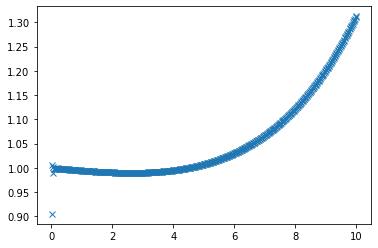

In [366]:
plt.plot(rs[mid:],pot_x[5]*rs[mid:],'x')

## Optimal Factor: NN = 1536

100%|██████████| 5/5 [53:09<00:00, 637.92s/it]


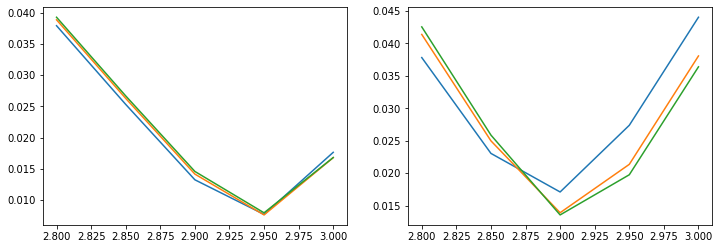

optimal factor for x   (0 < d < 5):  2.950
optimal factor for xy  (0 < d < 5):  2.950
optimal factor for xyz (0 < d < 5):  2.950
optimal factor for x   (0 < d < 7):  2.900
optimal factor for xy  (0 < d < 7):  2.900
optimal factor for xyz (0 < d < 7):  2.900


In [374]:
props = generate_props(1536,10.0)

xs = props['xs']
mid = props['mid']
rs = props['rs']
rs_diag = np.sqrt(2.0*xs**2+(xs[mid])**2)
rs_full_diag = np.sqrt(3.0*xs**2)


pot_x = []
pot_xy = []
pot_xyz = []

merits_5 = []
merits_7 = []

factors = np.linspace(2.8,3.0,5)

for factor in tqdm.tqdm(factors):

    chunked_prepare_delta('test_v1.h5',props)
    chunked_get_potential_v1('test_v1.h5',props,factor,64,debug=False, workers=6)

    pot_x_axis = np.real(get_axis('test_v1.h5',props,axis=0))
    pot_xy_axis = np.real(get_diagonal('test_v1.h5',props,axis=2))
    pot_xyz_axis = np.real(get_full_diagonal('test_v1.h5',props,axis=0))

    pot_x.append(pot_x_axis)
    pot_xy.append(pot_xy_axis)
    pot_xyz.append(pot_xyz_axis)
    
    merits_5.append([merit(pot_x_axis,rs[mid:],5),merit(pot_xy_axis,rs_diag[mid:],5),merit(pot_xyz_axis,rs_full_diag[mid:],5)])
    merits_7.append([merit(pot_x_axis,rs[mid:],7),merit(pot_xy_axis,rs_diag[mid:],7),merit(pot_xyz_axis,rs_full_diag[mid:],7)])

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(factors,np.array(merits_5))
plt.subplot(1,2,2)
plt.plot(factors,np.array(merits_7))
plt.show()

print(f"optimal factor for x   (0 < d < 5):  {factors[np.argmin(np.array(merits_5)[:,0])]:.3f}")
print(f"optimal factor for xy  (0 < d < 5):  {factors[np.argmin(np.array(merits_5)[:,1])]:.3f}")
print(f"optimal factor for xyz (0 < d < 5):  {factors[np.argmin(np.array(merits_5)[:,2])]:.3f}")

print(f"optimal factor for x   (0 < d < 7):  {factors[np.argmin(np.array(merits_7)[:,0])]:.3f}")
print(f"optimal factor for xy  (0 < d < 7):  {factors[np.argmin(np.array(merits_7)[:,1])]:.3f}")
print(f"optimal factor for xyz (0 < d < 7):  {factors[np.argmin(np.array(merits_7)[:,2])]:.3f}")

In [375]:
factors[3]

2.95

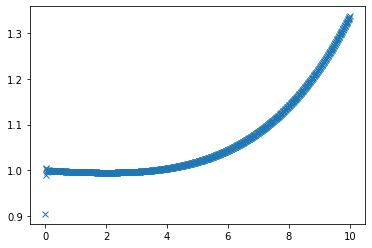

In [376]:
plt.plot(rs[mid:],pot_x[3]*rs[mid:],'x')

## Optimal Factor: NN = 2048

100%|██████████| 128/128 [09:01<00:00,  4.23s/it]


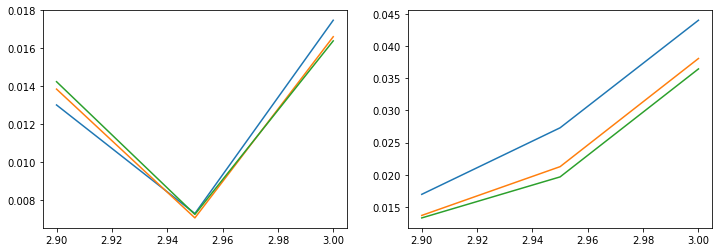

optimal factor for x   (0 < d < 5):  2.950
optimal factor for xy  (0 < d < 5):  2.950
optimal factor for xyz (0 < d < 5):  2.950
optimal factor for x   (0 < d < 7):  2.900
optimal factor for xy  (0 < d < 7):  2.900
optimal factor for xyz (0 < d < 7):  2.900
CPU times: user 2h 42min 28s, sys: 58min 49s, total: 3h 41min 17s
Wall time: 1h 22min 14s


In [435]:
%%time

props = generate_props(2048,10.0)

xs = props['xs']
mid = props['mid']
rs = props['rs']
rs_diag = np.sqrt(2.0*xs**2+(xs[mid])**2)
rs_full_diag = np.sqrt(3.0*xs**2)


pot_x = []
pot_xy = []
pot_xyz = []

merits_5 = []
merits_7 = []

factors = np.linspace(2.8,3.0,5)

for factor in factors:

    chunked_prepare_delta('test_v1.h5',props)
    chunked_get_potential_v1('test_v1.h5',props,factor,128,debug=True, workers=6)

    pot_x_axis = np.real(get_axis('test_v1.h5',props,axis=0))
    pot_xy_axis = np.real(get_diagonal('test_v1.h5',props,axis=2))
    pot_xyz_axis = np.real(get_full_diagonal('test_v1.h5',props,axis=0))

    pot_x.append(pot_x_axis)
    pot_xy.append(pot_xy_axis)
    pot_xyz.append(pot_xyz_axis)
    
    merits_5.append([merit(pot_x_axis,rs[mid:],5),merit(pot_xy_axis,rs_diag[mid:],5),merit(pot_xyz_axis,rs_full_diag[mid:],5)])
    merits_7.append([merit(pot_x_axis,rs[mid:],7),merit(pot_xy_axis,rs_diag[mid:],7),merit(pot_xyz_axis,rs_full_diag[mid:],7)])

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(factors,np.array(merits_5))
plt.subplot(1,2,2)
plt.plot(factors,np.array(merits_7))
plt.show()

print(f"optimal factor for x   (0 < d < 5):  {factors[np.argmin(np.array(merits_5)[:,0])]:.3f}")
print(f"optimal factor for xy  (0 < d < 5):  {factors[np.argmin(np.array(merits_5)[:,1])]:.3f}")
print(f"optimal factor for xyz (0 < d < 5):  {factors[np.argmin(np.array(merits_5)[:,2])]:.3f}")

print(f"optimal factor for x   (0 < d < 7):  {factors[np.argmin(np.array(merits_7)[:,0])]:.3f}")
print(f"optimal factor for xy  (0 < d < 7):  {factors[np.argmin(np.array(merits_7)[:,1])]:.3f}")
print(f"optimal factor for xyz (0 < d < 7):  {factors[np.argmin(np.array(merits_7)[:,2])]:.3f}")

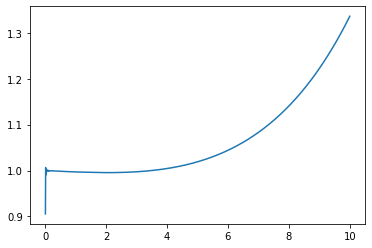

In [451]:
plt.plot(rs[mid:],pot_x[1]*rs[mid:],'-')

## Extracting Running times

| NN | N_r | T_t | t_i (s) |
|---  | --- | --- | --- |
| 256 | 21 |  0:43 | 0.5 |
| 512 | 21 |  5:53 | 17  |
|1024 | 13 | 38:33 | 178 |
|1536 |  5 | 53:09 | 637 |
|2048 |  3 | 82:14 | 1644 |

3.2920662789708297 -17.683405565892404


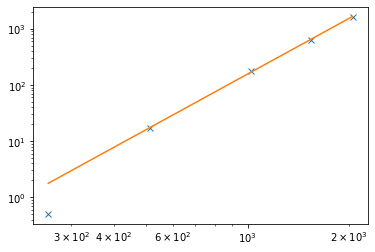

In [439]:
NNs = np.array([256,512,1024,1536,2048])
ts = np.array([0.5,17,178,637,1644])

a,b = np.polyfit(np.log(NNs[1:]),np.log(ts[1:]),1)
print(a,b)


a0 = 3.292
b0 = -17.683

def time_estimate(NN):
    return NN**a0*np.exp(b0)

plt.loglog(NNs,ts,'x')
plt.loglog(NNs,time_estimate(NNs))
plt.show()

## Check the latest results

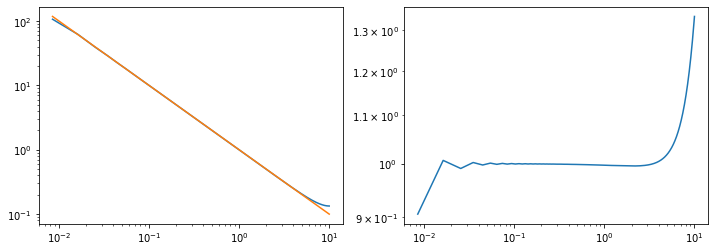

In [447]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.loglog(rs[mid:],pot_x[1],'-')
plt.loglog(rs[mid:],1/rs[mid:],'-')
plt.subplot(1,2,2)
plt.loglog(rs[mid:],pot_x[1]*rs[mid:],'-')

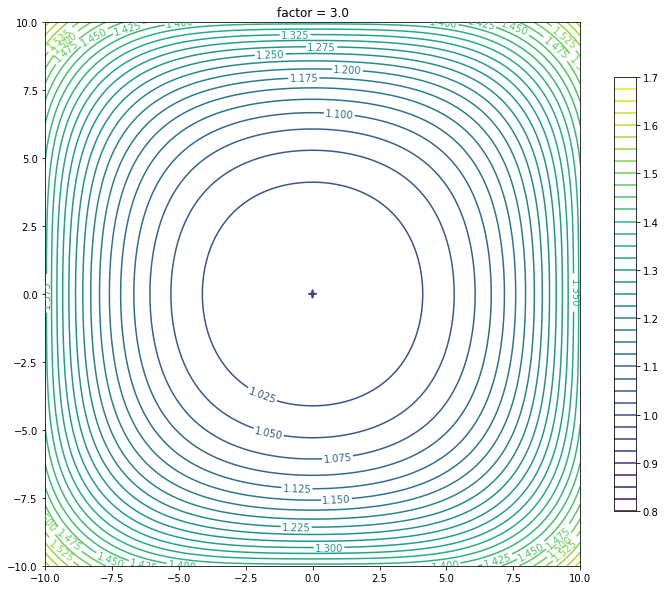

In [500]:
aa = np.real(get_plane('test_v1.h5',props))
xx,yy = np.meshgrid(xs,xs)
coords = np.sqrt(xx**2+yy**2+xs[mid]**2)

fig, ax = plt.subplots(figsize=(12,10))
CS = ax.contour(xx,yy, aa*coords,levels=np.linspace(0.8,1.7,37))
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('factor = 3.0')
CB = fig.colorbar(CS, shrink=0.8)
plt.show()

## Determine the deviation from sphericity...

In [502]:
from scipy.interpolate import RegularGridInterpolator

In [542]:
## use an exponential interpolations
interp = RegularGridInterpolator((xs, xs), np.log(aa))

In [543]:

thetas = np.linspace(0,np.pi/2,60)
points1 = 1.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points2 = 2.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points3 = 3.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points4 = 4.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points5 = 5.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points6 = 6.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points7 = 7.0*np.array([np.cos(thetas),np.sin(thetas)]).T
points8 = 8.0*np.array([np.cos(thetas),np.sin(thetas)]).T


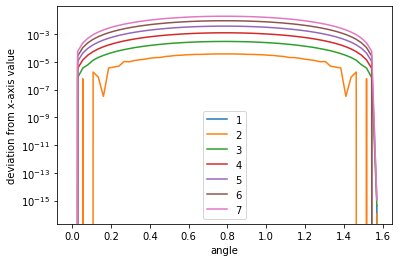

In [548]:
plt.plot(thetas,1-np.exp(interp(points1)-interp(points1)[0]),label='1')
plt.plot(thetas,1-np.exp(interp(points2)-interp(points2)[0]),label='2')
plt.plot(thetas,1-np.exp(interp(points3)-interp(points3)[0]),label='3')
plt.plot(thetas,1-np.exp(interp(points4)-interp(points4)[0]),label='4')
plt.plot(thetas,1-np.exp(interp(points5)-interp(points5)[0]),label='5')
plt.plot(thetas,1-np.exp(interp(points6)-interp(points6)[0]),label='6')
plt.plot(thetas,1-np.exp(interp(points7)-interp(points7)[0]),label='7')

plt.yscale('log')

plt.xlabel('angle')
plt.ylabel('deviation from x-axis value')
plt.legend()
plt.show()
#plt.plot(thetas,interp(points8)/interp(points8)[0])